100%|██████████| 170498071/170498071 [00:05<00:00, 29980234.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 169001437/169001437 [00:02<00:00, 59496976.08it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


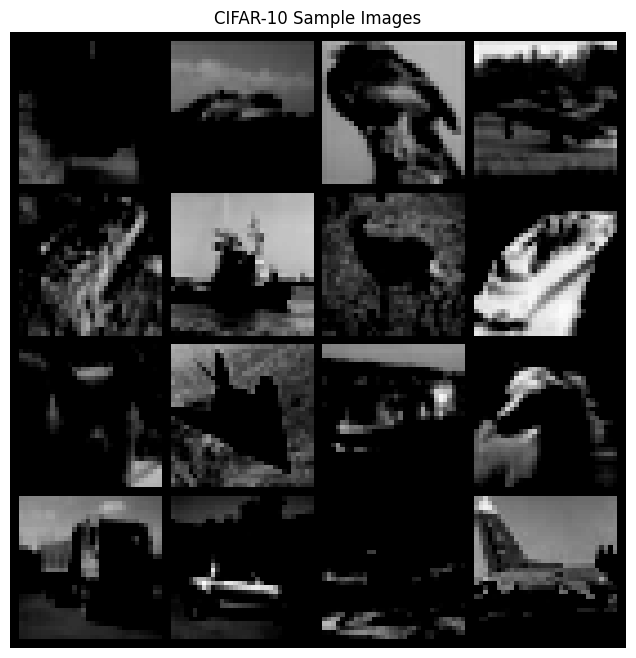

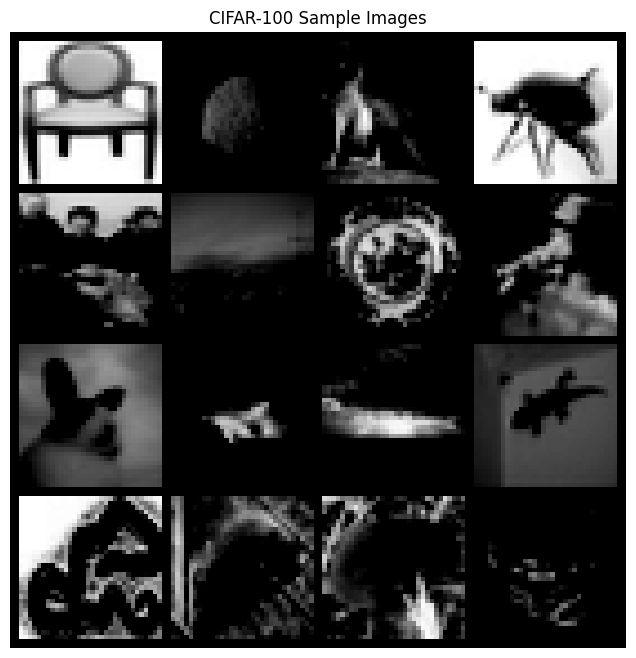

In [5]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models
from kan import KAN  # Import Efficient KAN
import os

# Set CUDA_LAUNCH_BLOCKING to get accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check devices
cpu_device = torch.device("cpu")
gpu_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define datasets and transformations
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)

batch_size = 16  # Reduced batch size for faster testing

# Data loaders
cifar10_loader = torch.utils.data.DataLoader(cifar10, batch_size=batch_size, shuffle=True)
cifar100_loader = torch.utils.data.DataLoader(cifar100, batch_size=batch_size, shuffle=True)

# Visualize datasets
def visualize_dataset(loader, title):
    batch = next(iter(loader))
    images, labels = batch
    plt.figure(figsize=(8, 8))
    grid_img = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

visualize_dataset(cifar10_loader, "CIFAR-10 Sample Images")
visualize_dataset(cifar100_loader, "CIFAR-100 Sample Images")



In [ ]:
# Adjust models for different datasets
def modify_model_input_channels(model, in_channels):
    if isinstance(model, models.ResNet):
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    elif isinstance(model, models.VGG):
        model.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
    return model

# Define training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            # Flatten the inputs only if the model is KAN
            if isinstance(model, KAN):
                inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epoch_losses

def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Flatten the inputs only if the model is KAN
            if isinstance(model, KAN):
                inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def model_summary(model):
    summary_str = str(model)
    num_params = sum(p.numel() for p in model.parameters())
    param_size = sum(p.element_size() * p.nelement() for p in model.parameters())
    return summary_str, num_params, param_size

# Pretty print results function
def pretty_print_results(row):
    print(f"Model: {row['Model']}")
    print(f"Dataset: {row['Dataset']}")
    print(f"Epochs: {row['Epochs']}")
    print(f"Accuracy: {row['Accuracy']:.2f}%")
    print(f"Training Time: {row['Training Time']:.2f}s")
    print(f"Number of Parameters: {row['Parameters']}")
    print(f"Parameter Size: {row['Param Size'] / 1e6:.2f} MB")
    print(f"Device: {row['Device']}")

# Initialize DataFrame to track results
results_df = pd.DataFrame(columns=["Model", "Dataset", "Epochs", "Accuracy", "Training Time", "Parameters", "Param Size", "Model Summary", "Device"])

# Define KAN models first
hidden_layers_list = [
    [32*32, 64, 10],     # 1 layer
    [32*32, 128, 10],    # 1 layer
    [32*32, 256, 10],    # 1 layer
    [32*32, 128, 256, 10],  # 2 layers
    [32*32, 128, 512, 10],  # 2 layers
    [32*32, 128, 256, 512, 10],  # 3 layers
]

grid_sizes = [4, 8, 16]  # Adjusted grid sizes to match 32x32 images
prune_options = [False]  # Prune or not

models_to_test = {}

for layers in hidden_layers_list:
    for grid_size in grid_sizes:
        for prune in prune_options:
            input_size = 32 * 32  # 1024 for 32x32 images (grayscale)
            models_to_test[f"E-KAN_{len(layers)}_layers_{layers[1] if len(layers) > 1 else layers[0]}_units_grid_{grid_size}_prune_{prune}"] = KAN(layers, grid_size)

# Define other models to test for CIFAR-10
models_to_test.update({
    "ResNet18_CIFAR10": modify_model_input_channels(models.resnet18(weights=None, num_classes=10), 1),
    "VGG16_CIFAR10": modify_model_input_channels(models.vgg16(weights=None, num_classes=10), 1),
    "ResNet50_CIFAR10": modify_model_input_channels(models.resnet50(weights=None, num_classes=10), 1),
    "VGG19_CIFAR10": modify_model_input_channels(models.vgg19(weights=None, num_classes=10), 1),
})

# Define number of epochs to test
epoch_list = [2, 5, 10]  # Set to 1 for testing

# Function to save results
def save_results(df, file_name):
    df.to_csv(file_name, index=False)

# Function to load results if available
def load_results(file_name):
    try:
        return pd.read_csv(file_name)
    except FileNotFoundError:
        return pd.DataFrame(columns=["Model", "Dataset", "Epochs", "Accuracy", "Training Time", "Parameters", "Param Size", "Model Summary", "Device"])

results_file = "model_results_CIFAR10.csv"
results_df = load_results(results_file)

# Train and evaluate each model on CIFAR-10 on GPU
for model_name, model in models_to_test.items():
    for num_epochs in epoch_list:
        for device_type in [gpu_device]:
            device = device_type
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
            start_time = time.time()
            epoch_losses = train_model(model, cifar10_loader, criterion, optimizer, num_epochs=num_epochs)
            train_time = time.time() - start_time
            accuracy = evaluate_model(model, cifar10_loader, criterion)
            summary_str, num_params, param_size = model_summary(model)

            device_name = "GPU" if device_type == gpu_device else "CPU"

            # Save results to DataFrame
            new_row = pd.DataFrame({
                "Model": [model_name],
                "Dataset": ["CIFAR-10"],
                "Epochs": [num_epochs],
                "Accuracy": [accuracy],
                "Training Time": [train_time],
                "Parameters": [num_params],
                "Param Size": [param_size],
                "Model Summary": [summary_str],
                "Device": [device_name]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            save_results(results_df, results_file)
            pretty_print_results(new_row.iloc[0])

# Plot CIFAR-10 results
plt.figure(figsize=(12, 8))
for model_name in results_df[results_df['Dataset'] == "CIFAR-10"]['Model'].unique():
    subset = results_df[results_df['Model'] == model_name]
    plt.plot(subset['Epochs'], subset['Accuracy'], label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison on CIFAR-10')
plt.legend()
plt.show()



Epoch 1/2:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1/2, Loss: 1.7789


Epoch 2/2:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2/2, Loss: 1.5844
Model: E-KAN_3_layers_64_units_grid_4_prune_False
Dataset: CIFAR-10
Epochs: 2
Accuracy: 47.55%
Training Time: 131.51s
Number of Parameters: 595584
Parameter Size: 2.38 MB
Device: GPU


Epoch 1/5:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1/5, Loss: 1.4994


Epoch 2/5:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2/5, Loss: 1.4384


Epoch 3/5:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3/5, Loss: 1.3906


Epoch 4/5:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4/5, Loss: 1.3456


Epoch 5/5:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5/5, Loss: 1.3056
Model: E-KAN_3_layers_64_units_grid_4_prune_False
Dataset: CIFAR-10
Epochs: 5
Accuracy: 57.01%
Training Time: 328.59s
Number of Parameters: 595584
Parameter Size: 2.38 MB
Device: GPU


Epoch 1/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.2701


Epoch 2/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.2330


Epoch 3/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.1998


Epoch 4/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.1643


Epoch 5/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.1395


Epoch 6/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.1059


Epoch 7/10:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.0779


Epoch 8/10:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:

# Define KAN models first
hidden_layers_list = [
    [32*32, 64, 100],     # 1 layer
    [32*32, 128, 100],    # 1 layer
    [32*32, 256, 100],    # 1 layer
    [32*32, 128, 256, 100],  # 2 layers
    [32*32, 128, 512, 100],  # 2 layers
    [32*32, 128, 256, 512, 100],  # 3 layers
]

grid_sizes = [4, 8, 16]  # Adjusted grid sizes to match 32x32 images
prune_options = [False]  # Prune or not

models_to_test = {}

for layers in hidden_layers_list:
    for grid_size in grid_sizes:
        for prune in prune_options:
            input_size = 32 * 32  # 1024 for 32x32 images (grayscale)
            models_to_test[f"E-KAN_{len(layers)}_layers_{layers[1] if len(layers) > 1 else layers[0]}_units_grid_{grid_size}_prune_{prune}"] = KAN(layers, grid_size)



# Define other models to test for CIFAR-100
models_to_test.update({
    "ResNet18_CIFAR100": modify_model_input_channels(models.resnet18(weights=None, num_classes=100), 1),
    "VGG16_CIFAR100": modify_model_input_channels(models.vgg16(weights=None, num_classes=100), 1),
    "ResNet50_CIFAR100": modify_model_input_channels(models.resnet50(weights=None, num_classes=100), 1),
    "VGG19_CIFAR100": modify_model_input_channels(models.vgg19(weights=None, num_classes=100), 1),
})

# Train and evaluate each model on CIFAR-100 on GPU
for model_name, model in models_to_test.items():
    for num_epochs in epoch_list:
        for device_type in [gpu_device]:
            device = device_type
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
            start_time = time.time()
            epoch_losses = train_model(model, cifar100_loader, criterion, optimizer, num_epochs=num_epochs)
            train_time = time.time() - start_time
            accuracy = evaluate_model(model, cifar100_loader, criterion)
            summary_str, num_params, param_size = model_summary(model)

            device_name = "GPU" if device_type == gpu_device else "CPU"

            # Save results to DataFrame
            new_row = pd.DataFrame({
                "Model": [model_name],
                "Dataset": ["CIFAR-100"],
                "Epochs": [num_epochs],
                "Accuracy": [accuracy],
                "Training Time": [train_time],
                "Parameters": [num_params],
                "Param Size": [param_size],
                "Model Summary": [summary_str],
                "Device": [device_name]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            save_results(results_df, results_file)
            pretty_print_results(new_row.iloc[0])

# Plot CIFAR-100 results
plt.figure(figsize=(12, 8))
for model_name in results_df[results_df['Dataset'] == "CIFAR-100"]['Model'].unique():
    subset = results_df[results_df['Model'] == model_name]
    plt.plot(subset['Epochs'], subset['Accuracy'], label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison on CIFAR-100')
plt.legend()
plt.show()

# Display final results
print(results_df)

results_file = "model_results_CIFAR100.csv"
results_df = load_results(results_file)


